In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import requests
from bs4 import BeautifulSoup
import re

from wordcloud import WordCloud

# stopwords
import nltk
stop_words = nltk.corpus.stopwords.words('english')
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from datetime import datetime

In [83]:
# initialize the empty dataframe
df = pd.DataFrame(columns=['URL', 'Heading', 'SubHeadings', 'Content'])

In [84]:
def get_links_from_bbc_news():
    res = requests.get('https://www.bbc.com/news')

    # Check if the request was successful
    if res.status_code == 200:
        # Parse the HTML content of the page
        soup_data = BeautifulSoup(res.text, 'html.parser')

        # Find the parent div with class 'nw-c-top-stories--international'
        top_stories_div = soup_data.find('div', class_='nw-c-top-stories--international')

        # Check if the 'nw-c-top-stories--international' div was found
        if top_stories_div:
            # Find all <a> tags within the 'top_stories_div' with a class containing 'gs-c-promo-heading'
            promo_headings = top_stories_div.find_all('a', class_=lambda x: x and 'gs-c-promo-heading' in x)

            # Extract the links from the promo_headings
            links = [heading['href'] for heading in promo_headings]

            # Return the links
            return links
        else:
            print("The 'nw-c-top-stories--international' div was not found on the page.")
    else:
        print("Failed to retrieve the page. Status code:", res.status_code)


In [85]:
links = get_links_from_bbc_news()
len(links)

16

In [86]:
# drop duplicates
links = list(set(links))
links = [link for link in links if 'live' not in link]
links

['/news/world-australia-67340901',
 '/news/world-asia-67353331',
 '/news/world-australia-67354430',
 '/news/uk-67344299',
 '/news/world-australia-67353831',
 '/news/world-middle-east-67327079',
 '/news/world-us-canada-67354706',
 '/news/world-us-canada-67352011',
 '/sport/rugby-union/67349016',
 '/news/science-environment-67332791',
 '/news/world-us-canada-67352378',
 '/news/uk-wales-67344916',
 '/news/newsbeat-67355245']

In [87]:
# assign the links to the dataframe
new_links = [link for link in links if not df['URL'].isin([link]).any()]
if new_links:
    new_df = pd.DataFrame({'URL': new_links})
    df = pd.concat([df, new_df], ignore_index=True)
df

,URL,Heading,SubHeadings,Content
0,/news/world-australia-67340901,NaN,NaN,NaN
1,/news/world-asia-67353331,NaN,NaN,NaN
2,/news/world-australia-67354430,NaN,NaN,NaN
3,/news/uk-67344299,NaN,NaN,NaN
4,/news/world-australia-67353831,NaN,NaN,NaN
5,/news/world-middle-east-67327079,NaN,NaN,NaN
6,/news/world-us-canada-67354706,NaN,NaN,NaN
7,/news/world-us-canada-67352011,NaN,NaN,NaN
8,/sport/rugby-union/67349016,NaN,NaN,NaN
9,/news/science-environment-67332791,NaN,NaN,NaN


In [88]:
MAIN_URL = 'https://www.bbc.com'

In [92]:
def requestArticle(idx, url):
    url_to_fetch = MAIN_URL + url

    # Send an HTTP GET request to the specified URL
    res = requests.get(url_to_fetch)

    # Check if the request was successful
    if res.status_code == 200:

        # df.loc[idx, 'RequestDate'] = pd.Timestamp.now()

        # Parse the HTML content of the page
        soup_data = BeautifulSoup(res.text, 'html.parser')

        meta = soup_data.find('meta', attrs={'property': 'article:section'})

        if meta:
            # print("Topic:", meta['content'])
            df.loc[idx, 'Topic'] = meta['content']

        # Find the <article> tag and get all elements inside it
        article = soup_data.find('article')

        if article:
            # Find all elements (tags) inside the <article> tag
            article_elements = article.find_all()
            
            # Extract the heading
            heading = article.find('h1').text
            # print("Heading")
            # print(heading)

            # Extract the subheadings
            # get headlines with data-component="subheadline-block"
            subheadings = article.find_all('div', attrs={'data-component': 'subheadline-block'})
            subheadings = [subheading for subheading in subheadings if 'You may also be interested in:' not in subheading.text]
            subheadings = [subheading.text for subheading in subheadings]
            subheadings = (', ').join(subheadings)
            # print("SubHeading")
            # print(subheadings)


            # Extract the content
            content = '\n'.join([element.text for element in article_elements if element.name == 'p'])
            # print("Content")
            # print(content)

            # Update the dataframe
            df.loc[idx, 'Heading'] = heading
            df.loc[idx, 'SubHeadings'] = subheadings
            df.loc[idx, 'Content'] = content
            df.loc[idx, 'RequestDate'] = pd.Timestamp.now()
            

        else:
            print("No <article> tag found on the page.")

    else:
        print("Failed to retrieve the page. Status code:", res.status_code)


In [93]:
# Loop through the links and request each article
for idx, link in enumerate(links):
    requestArticle(idx, link)

In [94]:
import os.path

# check if csv file exists
if os.path.isfile('bbc_news.csv'):
    # read the csv file
    existing_df = pd.read_csv('bbc_news.csv')
    
    # check if new URLs already exist in the csv file
    new_links = [link for link in links if not existing_df['URL'].isin([link]).any()]
    
    # append new data to the csv file
    if new_links:
        new_df = pd.DataFrame({'URL': new_links})
        df = pd.concat([existing_df, new_df], ignore_index=True)
        df.to_csv('bbc_news.csv', index=False)
else:
    # export the dataframe to csv
    df.to_csv('bbc_news.csv', index=False)

# display the dataframe
df

,URL,Heading,SubHeadings,Content,Topic,RequestDate
0,/news/world-australia-67340901,Optus outage: Millions affected by Australian ...,,Millions of Australians were left without mobi...,Australia,2023-11-08 12:11:27.929995
1,/news/uk-england-wiltshire-67336495,Legend of Zelda: Nintendo & Sony making live-a...,,Nintendo and Sony Pictures are making a live-a...,Asia,2023-11-08 12:11:28.027200
2,/news/world-asia-67353331,Australian farmer Colin Deveraux survives croc...,,An Australian farmer says he is lucky to be al...,Australia,2023-11-08 12:11:28.125302
3,/news/world-australia-67354430,Nitrous oxide: Laughing gas possession becomes...,What does nitrous oxide do to the body?,"Possession of nitrous oxide, also known as NOS...",UK,2023-11-08 12:11:28.228363
4,/news/uk-67344299,"Australia indefinite detention unlawful, High ...",,Australia's top court has ruled that the gover...,Australia,2023-11-08 12:11:28.321876
5,/news/world-australia-67353831,'Iâm calling from Israeli intelligence. We h...,"'We will bomb three towers', 'Fire a warning s...",The call to Mahmoud Shaheen came at dawn.\nIt ...,Middle East,2023-11-08 12:11:28.438713
6,/news/world-middle-east-67327079,Rashida Tlaib censured over Israel-Gaza comments,More on Israel-Gaza war,The US Congress has voted to censure its only ...,US & Canada,2023-11-08 12:11:28.538642
7,/news/world-us-canada-67354706,Ohio votes to add abortion rights to state con...,More on US abortion debate,Ohio voted to enshrine abortion rights in its ...,US & Canada,2023-11-08 12:11:28.643164
8,/news/world-us-canada-67352011,Wayne Barnes: Rugby World Cup final referee on...,,Last updated on 3 hours ago3 hours ago.From th...,US & Canada,2023-11-08 12:11:28.781794
9,/news/science-environment-67332791,Global heat: 'Exceptional' autumn sets 2023 up...,"'Record human suffering', Impacts of rising te...","It is now ""virtually certain"" that 2023 - a ye...",Science & Environment,2023-11-08 12:11:28.893868


In [95]:
def cleanText(text):
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens] # everything lowercase
    tokens = [word.strip() for word in tokens] # strips whitespaces
    tokens = [word for word in tokens if word.isalnum()] # only alpha numerical values
    tokens = [word for word in tokens if not word in stop_words] # removes stopwords
    return tokens 

In [97]:
df.fillna('', inplace=True)
df['Cleaned_Heading'] = df['Heading'].apply(cleanText)
df['Cleaned_SubHeadings'] = df['SubHeadings'].apply(cleanText)
df['Cleaned_Content'] = df['Content'].apply(cleanText)


In [98]:
df

,URL,Heading,SubHeadings,Content,Topic,RequestDate,Cleaned_Heading,Cleaned_SubHeadings,Cleaned_Content
0,/news/world-australia-67340901,Optus outage: Millions affected by Australian ...,,Millions of Australians were left without mobi...,Australia,2023-11-08 12:11:27.929995,"[optus, outage, millions, affected, australian...",[],"[millions, australians, left, without, mobile,..."
1,/news/uk-england-wiltshire-67336495,Legend of Zelda: Nintendo & Sony making live-a...,,Nintendo and Sony Pictures are making a live-a...,Asia,2023-11-08 12:11:28.027200,"[legend, zelda, nintendo, sony, making, movie]",[],"[nintendo, sony, pictures, making, film, belov..."
2,/news/world-asia-67353331,Australian farmer Colin Deveraux survives croc...,,An Australian farmer says he is lucky to be al...,Australia,2023-11-08 12:11:28.125302,"[australian, farmer, colin, deveraux, survives...",[],"[australian, farmer, says, lucky, alive, repel..."
3,/news/world-australia-67354430,Nitrous oxide: Laughing gas possession becomes...,What does nitrous oxide do to the body?,"Possession of nitrous oxide, also known as NOS...",UK,2023-11-08 12:11:28.228363,"[nitrous, oxide, laughing, gas, possession, be...","[nitrous, oxide, body]","[possession, nitrous, oxide, also, known, nos,..."
4,/news/uk-67344299,"Australia indefinite detention unlawful, High ...",,Australia's top court has ruled that the gover...,Australia,2023-11-08 12:11:28.321876,"[australia, indefinite, detention, unlawful, h...",[],"[australia, top, court, ruled, government, pow..."
5,/news/world-australia-67353831,'Iâm calling from Israeli intelligence. We h...,"'We will bomb three towers', 'Fire a warning s...",The call to Mahmoud Shaheen came at dawn.\nIt ...,Middle East,2023-11-08 12:11:28.438713,"[calling, israeli, intelligence, order, bomb, ...","[bomb, three, towers, warning, shot, prove, re...","[call, mahmoud, shaheen, came, dawn, thursday,..."
6,/news/world-middle-east-67327079,Rashida Tlaib censured over Israel-Gaza comments,More on Israel-Gaza war,The US Congress has voted to censure its only ...,US & Canada,2023-11-08 12:11:28.538642,"[rashida, tlaib, censured, comments]",[war],"[us, congress, voted, censure, member, comment..."
7,/news/world-us-canada-67354706,Ohio votes to add abortion rights to state con...,More on US abortion debate,Ohio voted to enshrine abortion rights in its ...,US & Canada,2023-11-08 12:11:28.643164,"[ohio, votes, add, abortion, rights, state, co...","[us, abortion, debate]","[ohio, voted, enshrine, abortion, rights, cons..."
8,/news/world-us-canada-67352011,Wayne Barnes: Rugby World Cup final referee on...,,Last updated on 3 hours ago3 hours ago.From th...,US & Canada,2023-11-08 12:11:28.781794,"[wayne, barnes, rugby, world, cup, final, refe...",[],"[last, updated, 3, hours, ago3, hours, section..."
9,/news/science-environment-67332791,Global heat: 'Exceptional' autumn sets 2023 up...,"'Record human suffering', Impacts of rising te...","It is now ""virtually certain"" that 2023 - a ye...",Science & Environment,2023-11-08 12:11:28.893868,"[global, heat, autumn, sets, 2023, break, reco...","[human, suffering, impacts, rising, temperatur...","[virtually, certain, 2023, year, deadly, heatw..."


In [99]:
# join all the tokens into a single string
df['MergedText'] = df['Cleaned_Heading'] + df['Cleaned_SubHeadings'] + df['Cleaned_Content']
df['MergedText'] = df['MergedText'].apply(lambda x: ' '.join(x))

df.head()

,URL,Heading,SubHeadings,Content,Topic,RequestDate,Cleaned_Heading,Cleaned_SubHeadings,Cleaned_Content,MergedText
0,/news/world-australia-67340901,Optus outage: Millions affected by Australian ...,,Millions of Australians were left without mobi...,Australia,2023-11-08 12:11:27.929995,"[optus, outage, millions, affected, australian...",[],"[millions, australians, left, without, mobile,...",optus outage millions affected australian netw...
1,/news/uk-england-wiltshire-67336495,Legend of Zelda: Nintendo & Sony making live-a...,,Nintendo and Sony Pictures are making a live-a...,Asia,2023-11-08 12:11:28.027200,"[legend, zelda, nintendo, sony, making, movie]",[],"[nintendo, sony, pictures, making, film, belov...",legend zelda nintendo sony making movie ninten...
2,/news/world-asia-67353331,Australian farmer Colin Deveraux survives croc...,,An Australian farmer says he is lucky to be al...,Australia,2023-11-08 12:11:28.125302,"[australian, farmer, colin, deveraux, survives...",[],"[australian, farmer, says, lucky, alive, repel...",australian farmer colin deveraux survives croc...
3,/news/world-australia-67354430,Nitrous oxide: Laughing gas possession becomes...,What does nitrous oxide do to the body?,"Possession of nitrous oxide, also known as NOS...",UK,2023-11-08 12:11:28.228363,"[nitrous, oxide, laughing, gas, possession, be...","[nitrous, oxide, body]","[possession, nitrous, oxide, also, known, nos,...",nitrous oxide laughing gas possession becomes ...
4,/news/uk-67344299,"Australia indefinite detention unlawful, High ...",,Australia's top court has ruled that the gover...,Australia,2023-11-08 12:11:28.321876,"[australia, indefinite, detention, unlawful, h...",[],"[australia, top, court, ruled, government, pow...",australia indefinite detention unlawful high c...


In [100]:
def TfIdfvectorGenerator(documents_preprocessed):
    """ Taking a corpus of documents which have been preprocessed and exist in string shape, 
    creates TFIDF representations and returns the representations, and the TFIDF vectorizer"""
    from datetime import datetime
    beg = datetime.now()
    vectorizer = TfidfVectorizer(min_df=1,
                                 max_df=0.75) 
    
    tfidf = vectorizer.fit_transform(documents_preprocessed)  #note that you must use the preprocessed documents in string 
                                                                #form for this function/method
    end = datetime.now()
    
    print('documents processed:',tfidf.shape[0])
    print('time spent:',end-beg)
    return tfidf, vectorizer

In [101]:
tfidf, vectorizer = TfIdfvectorGenerator(df['MergedText']) 

documents processed: 15
time spent: 0:00:00.009111


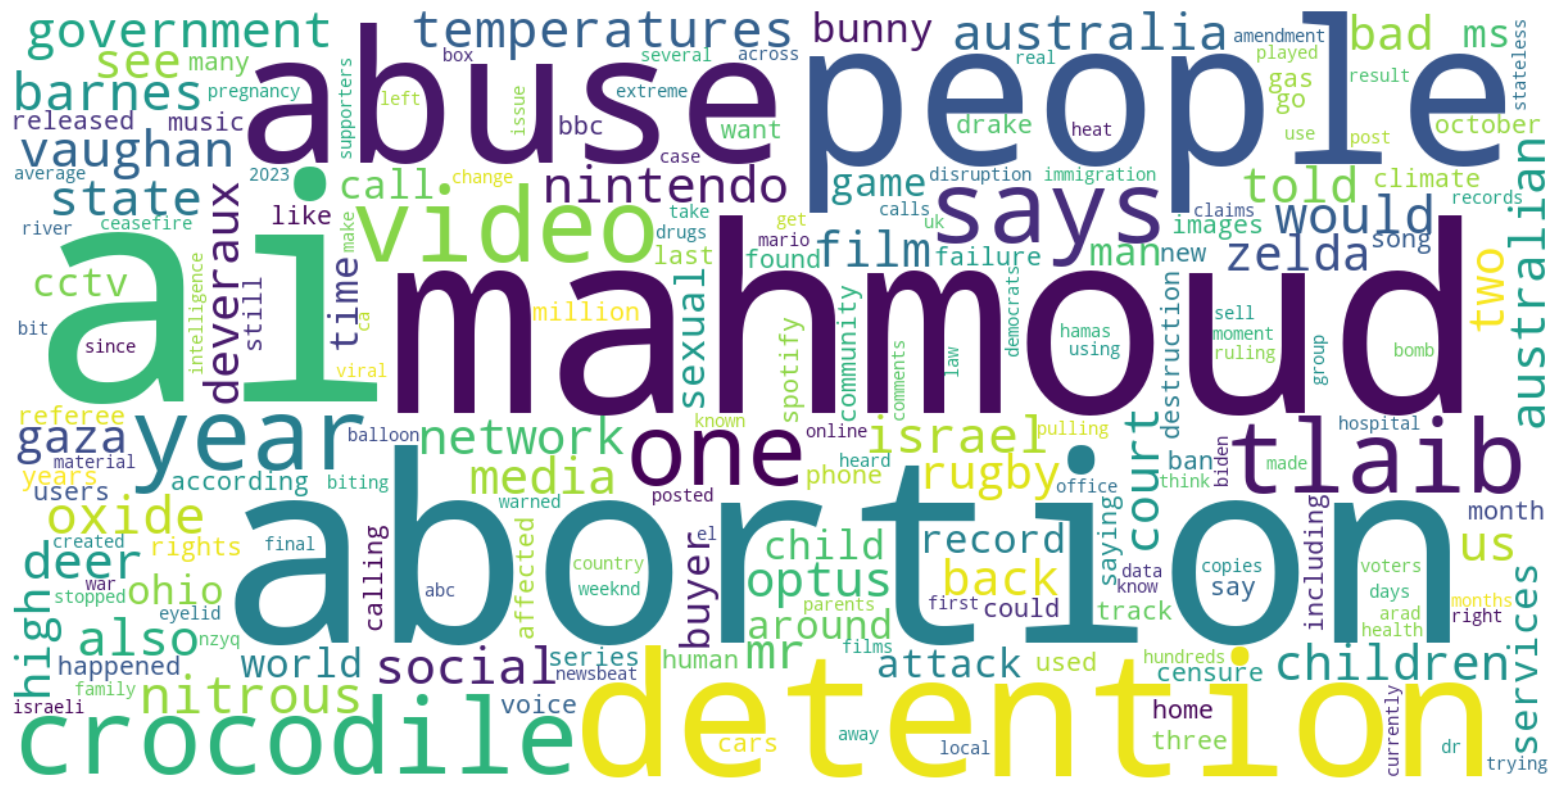

In [102]:
# Step 2: Rank words by TF-IDF scores
feature_names = vectorizer.get_feature_names_out()

# Get the TF-IDF scores for each word
tfidf_scores = tfidf.sum(axis=0).A1

# Create a dictionary of words and their TF-IDF scores
word_scores = dict(zip(feature_names, tfidf_scores))

# Step 3: Generate a word cloud
wordcloud = WordCloud(width=1200, height=600, background_color='white')
wordcloud.generate_from_frequencies(word_scores)

# Display the word cloud
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
# plt.show()
# date with time
todayDate = datetime.today().strftime('%Y-%m-%d-%H%M%S')
plt.savefig('clouds/' + todayDate + '_wordcloud.png', dpi=300)